## Importing Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode,substring, length, udf
from pyspark.sql.types import *
from pyspark.sql import Row
from itertools import cycle
from pyspark.ml.regression import LinearRegression
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import functions as F
from pyspark.sql import types as T

## Creating Spark session

In [2]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Loading data from the previous module

### Most invested categories

In [3]:
SQLQUERY =  """
            SELECT CATEGORY, Slope
            , Intercept
            , R2
            , Cast(Prediction as Decimal(12)) as Prediction
            FROM summaryDF      
            ORDER BY Prediction Desc
            LIMIT 5
            """
#  ORDER BY YEAR DESC, TOTAL DESC 
# Category,R2, Cast(Prediction as Decimal(12)) as Prediction
#ORDER BY Pediction Desc

regressionTopPredictedDF = spark.sql(SQLQUERY)
regressionTopPredictedDF.show(truncate = False)

+-------------------+--------------------+----------------------+------------------+-----------+
|CATEGORY           |Slope               |Intercept             |R2                |Prediction |
+-------------------+--------------------+----------------------+------------------+-----------+
|Biotechnology      |2.263097334319927E9 |-4.524211803974707E12 |0.8320372559570712|47244811352|
|E-Commerce         |2.1622207394859743E9|-4.3264826849430684E12|0.5349317056080214|41203208819|
|Software           |1.855957999989563E9 |-3.7093215007199204E12|0.660434615976291 |39713659259|
|Mobile             |1.568906102106968E9 |-3.137350074551301E12 |0.7083421147009286|31840251705|
|Enterprise Software|1.5422432218553917E9|-3.086112467756183E12 |0.6619147762786108|29218840392|
+-------------------+--------------------+----------------------+------------------+-----------+



### Top growing categories 

In [4]:
SQLQUERY =  """
            SELECT CATEGORY, Slope
            , Intercept
            , R2
            , Cast(Prediction as Decimal(12)) as Prediction
            FROM summaryDF      
            ORDER BY Slope Desc
            LIMIT 5
            """
#  ORDER BY YEAR DESC, TOTAL DESC 
# Category,R2, Cast(Prediction as Decimal(12)) as Prediction
#ORDER BY Pediction Desc

regressionTopGrowingDF = spark.sql(SQLQUERY)
regressionTopGrowingDF.show(truncate = False)

+-------------------+--------------------+----------------------+------------------+-----------+
|CATEGORY           |Slope               |Intercept             |R2                |Prediction |
+-------------------+--------------------+----------------------+------------------+-----------+
|Biotechnology      |2.263097334319927E9 |-4.524211803974707E12 |0.8320372559570712|47244811352|
|E-Commerce         |2.1622207394859743E9|-4.3264826849430684E12|0.5349317056080214|41203208819|
|Software           |1.855957999989563E9 |-3.7093215007199204E12|0.660434615976291 |39713659259|
|Mobile             |1.568906102106968E9 |-3.137350074551301E12 |0.7083421147009286|31840251705|
|Enterprise Software|1.5422432218553917E9|-3.086112467756183E12 |0.6619147762786108|29218840392|
+-------------------+--------------------+----------------------+------------------+-----------+



## Converting dataframe column to array

In [5]:
categoriesPredicted = regressionTopPredictedDF.select('CATEGORY')
categoriesGrowing = regressionTopGrowingDF.select('CATEGORY')
topCategoriesPredicted = [row.CATEGORY for row in categoriesPredicted.collect()]
topcategoriesGrowing = [row.CATEGORY for row in categoriesGrowing.collect()]

In [6]:
topCategoriesPredicted

['Biotechnology', 'E-Commerce', 'Software', 'Mobile', 'Enterprise Software']

In [7]:
topcategoriesGrowing

['Biotechnology', 'E-Commerce', 'Software', 'Mobile', 'Enterprise Software']

## Collecting the data set to plot regression lines

In [8]:
SQLQUERY =  """
            SELECT CATEGORY, 
            CAST(YEAR AS FLOAT), 
            SUM(RAISED_AMOUNT_USD) AS TOTAL, 
            CAST(SUM(RAISED_AMOUNT_USD) AS FLOAT) AS TOTAL_DEC 
            FROM INVESTMENTS 
            GROUP BY CATEGORY, YEAR
            ORDER BY CATEGORY, YEAR
            """
#  ORDER BY YEAR DESC, TOTAL DESC
pointsDF = spark.sql(SQLQUERY)
pointsDF.show(5);

+--------+------+------------+-----------+
|CATEGORY|  YEAR|       TOTAL|  TOTAL_DEC|
+--------+------+------------+-----------+
|      3D|2003.0|      3.64E8|     3.64E8|
|      3D|2005.0|   1129590.0|  1129590.0|
|      3D|2006.0|   4.20152E7|  4.20152E7|
|      3D|2007.0| 1.0037656E8|1.0037656E8|
|      3D|2008.0|1.67802633E8|1.6780264E8|
+--------+------+------------+-----------+
only showing top 5 rows



## Plotting the regression charts for the Top categories

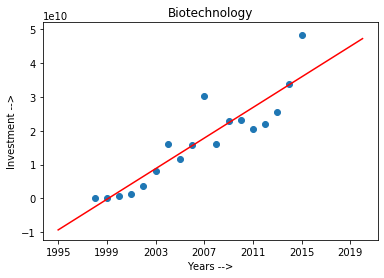

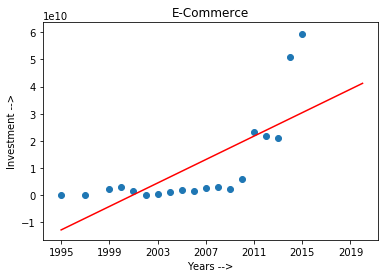

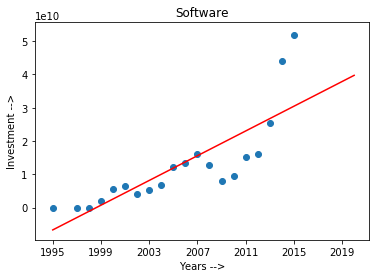

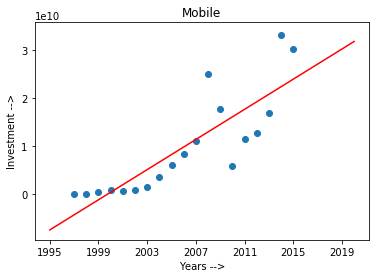

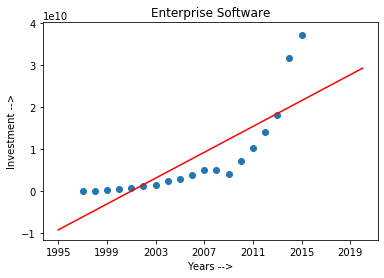

In [9]:
for category in topCategoriesPredicted:
    categoryDF=pointsDF.filter(pointsDF.CATEGORY == category)
    regressionTopPredictedCategoryDF=regressionTopPredictedDF.filter(regressionTopPredictedDF.CATEGORY == category)
    slope = [row.Slope for row in regressionTopPredictedCategoryDF.collect()][0]
    Intercept = [row.Intercept for row in regressionTopPredictedCategoryDF.collect()][0]
    #print(slope)
    x = [categoryDF.select('YEAR').collect()]
    y = [categoryDF.select('TOTAL_DEC').collect()] 
    
    Line = np.poly1d([slope, Intercept])
    xp = np.linspace(1995, 2020, 100)
    plt.plot(xp, Line(xp), c='r')
    
    plt.xticks(np.arange(1995, 2020, 4.0))
    plt.ylabel('Investment -->')  
    plt.xlabel('Years -->')  
    plt.title(category)
    
    plt.scatter(x, y)
    plotname = 'regression' + category + '.png'
    plt.savefig(plotname , pi=300, quality =95 )
    plt.show()